# Project 3

## Introduction

Housing affordability is one of the most pressing challenges facing New York City. In recent years, both rental prices and homelessness rates have increased, raising important policy questions about whether rising housing costs contribute to shelter entry.

This project examines the association between median asking rents and the NYC homeless shelter census over time. Using two publicly available datasets from the DHS Daily Shelter Census and Streeteasy city-wide median rent data, I analyze whether increases in rent are associated with changes in the number of individuals in shelter.

This analysis involves cleaning and transforming two datasets, aggregating rent and shelter data to the monthly level, merging them into a single dataset, and visualizing trends and relationships. The goal is not to claim causality, but to explore whether a clear association emerges between rising housing prices and homelessness in NYC.

## Project Prompt

- **Dataset(s) to be used:**
  - NYC DHS Daily Shelter Census: https://data.cityofnewyork.us/api/views/k46n-sa2m/rows.csv?accessType=DOWNLOAD
  - NYC Median Asking Rent (StreetEasy): https://cdn-charts.streeteasy.com/rentals/All/medianAskingRent_All.zip?_ga=2.152550206.667835091.1764904632-1105379344.1764904632


- **Analysis question:**
  How does the trend in median asking rent in New York City relate to the trend in the city’s homeless shelter population over time?


- **Columns that will (likely) be used:**
  - *From DHS Shelter Census:*
    - `Date of Census`
    - `Total Individuals in Shelter`
  - *From Median Rent dataset:*
    - `areaName`
    - Monthly rent columns (to be reshaped into a `month` column)
    - `median_rent`


- **Columns to be used to merge/join the datasets:**
  - DHS dataset: `month` (derived from `Date of Census`)
  - Rent dataset: `month` (converted from `YYYY-MM` column names)


- **Hypothesis:**
  Increases in median rent are associated with increases in the NYC homeless shelter population, reflecting affordability pressures that make it more difficult for households to remain housed.


## Load Packages and Import Data


In this section, I load the housing and homelessness datasets from local CSV files. The median rent data (`medianAskingRent_All.csv`) contains New York City–level median asking rents with one column per month (formatted as `YYYY-MM`). The DHS shelter census file (`DHS_Homeless_Shelter_Census_20251204.csv`) contains daily counts of the total number of individuals in NYC homeless shelters.

In the next section, I will reshape the rent data into a long format, convert dates, aggregate the shelter data to monthly averages, and merge the two datasets by month.

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
# Make plots display nicely
plt.style.use("default")

# 1. Read median rent data (wide format: one column per month)
rent_raw = pd.read_csv("medianAskingRent_All.csv")

# 2. Read DHS shelter census data (daily counts)
shelter_raw = pd.read_csv("DHS_Homeless_Shelter_Census_20251204.csv")

# Quick look at the data
rent_raw.head(), shelter_raw.head()

(              areaName    Borough   areaType  2010-01  2010-02  2010-03  \
 0         All Downtown  Manhattan  submarket   3200.0   3200.0   3015.0   
 1          All Midtown  Manhattan  submarket   2875.0   2800.0   2800.0   
 2  All Upper East Side  Manhattan  submarket   2450.0   2450.0   2400.0   
 3  All Upper Manhattan  Manhattan  submarket   1825.0   1800.0   1795.0   
 4  All Upper West Side  Manhattan  submarket   2895.0   2800.0   2750.0   
 
    2010-04  2010-05  2010-06  2010-07  ...  2025-01  2025-02  2025-03  \
 0   3100.0   3100.0   3200.0   3195.0  ...   4995.0   5000.0   5000.0   
 1   2850.0   2895.0   2950.0   3000.0  ...   4500.0   4580.0   4569.0   
 2   2500.0   2565.0   2570.0   2595.0  ...   3950.0   3995.0   3990.0   
 3   1800.0   1823.0   1850.0   1875.0  ...   2895.0   2868.0   2900.0   
 4   2800.0   2800.0   2795.0   2800.0  ...   4441.0   4450.0   4500.0   
 
    2025-04  2025-05  2025-06  2025-07  2025-08  2025-09  2025-10  
 0   5150.0   5250.0   5300.

## Data Cleaning and Preparation

This section prepares both datasets so they can be analyzed together on a common monthly basis.

1. **Median Rent Data (citywide NYC)**
   - Keep only the row corresponding to New York City (where `areaName` is "NYC").
   - Pivot the monthly columns (named in the format `YYYY-MM`) into a long format with two columns: `month` and `median_rent`.
   - Convert `month` into a proper date (using the first day of each month, e.g., `2021-03-01`).
   - Ensure `median_rent` is numeric.
   - Drop geographic identifier columns (`Borough`, `areaType`, `areaName`) that are no longer needed.

2. **Shelter Census Data (citywide NYC)**
   - Select the date of census and total individuals in shelter.
   - Convert the census date to a proper date type.
   - Create a `month` variable by flooring each date to the first day of the month.
   - Group by `month` and compute the **average number of individuals in shelter per month**.

3. **Joined Dataset**
   - Merge the long-format rent data and the monthly shelter averages by `month` using a left join.
   - Sort the resulting dataset chronologically.

In [16]:
# Prepare median rent data

# Keep only NYC row (areaName == "NYC")
rent_nyc = rent_raw[rent_raw["areaName"].isin(["NYC"])].copy()

# Identify columns that look like YYYY-MM (monthly columns)
month_cols = rent_nyc.columns[rent_nyc.columns.str.match(r"^\d{4}-\d{2}$")]

# Pivot monthly columns into long format: month, median_rent
rent_long = rent_nyc.melt(
    id_vars=["Borough", "areaType", "areaName"],
    value_vars=month_cols,
    var_name="month",
    value_name="median_rent"
)

# Convert month to proper datetime (YYYY-MM-01) and median_rent to numeric
rent_long["month"] = pd.to_datetime(rent_long["month"] + "-01")
rent_long["median_rent"] = pd.to_numeric(rent_long["median_rent"], errors="coerce")

# Drop geographic columns no longer needed (exactly as in the R code)
rent_long = rent_long.drop(columns=["Borough", "areaType", "areaName"])

# Prepare shelter data (monthly averages)

shelter = shelter_raw.rename(
    columns={
        "Date of Census": "date",
        "Total Individuals in Shelter": "total_shelter"
    }
)

# Convert date to datetime
shelter["date"] = pd.to_datetime(shelter["date"])

# Create a month column by flooring to the first day of each month
shelter["month"] = shelter["date"].dt.to_period("M").dt.to_timestamp()

# Group by month and compute average shelter population (total_shelter_avg)
shelter_monthly = (
    shelter.groupby("month", as_index=False)["total_shelter"]
           .mean()
           .rename(columns={"total_shelter": "total_shelter_avg"})
)

# Join rent and shelter data by month

df_joined = (
    rent_long
    .merge(shelter_monthly, on="month", how="left")
    .sort_values("month")
)
df_joined = df_joined.dropna(subset=["total_shelter_avg"])

## Visualizing Housing Costs and Homelessness Trends

To understand how housing affordability and homelessness evolve over time in New York City, I plot two separate monthly time-series. The first shows changes in median asking rent across NYC, and the second shows changes in the average number of individuals in homeless shelters for the same period.

Plotting these trends side by side allows for a clear visual comparison of how both series move over time. While these graphs do not establish causality, they help reveal whether increases in rent coincide with changes in shelter population, providing initial insight into how housing costs may relate to homelessness patterns in the city.

I also create a scatterplot to examine the association between the two variables directly. This visualization plots median rent against shelter population, allowing us to see whether higher rent levels correspond to increases in homelessness.



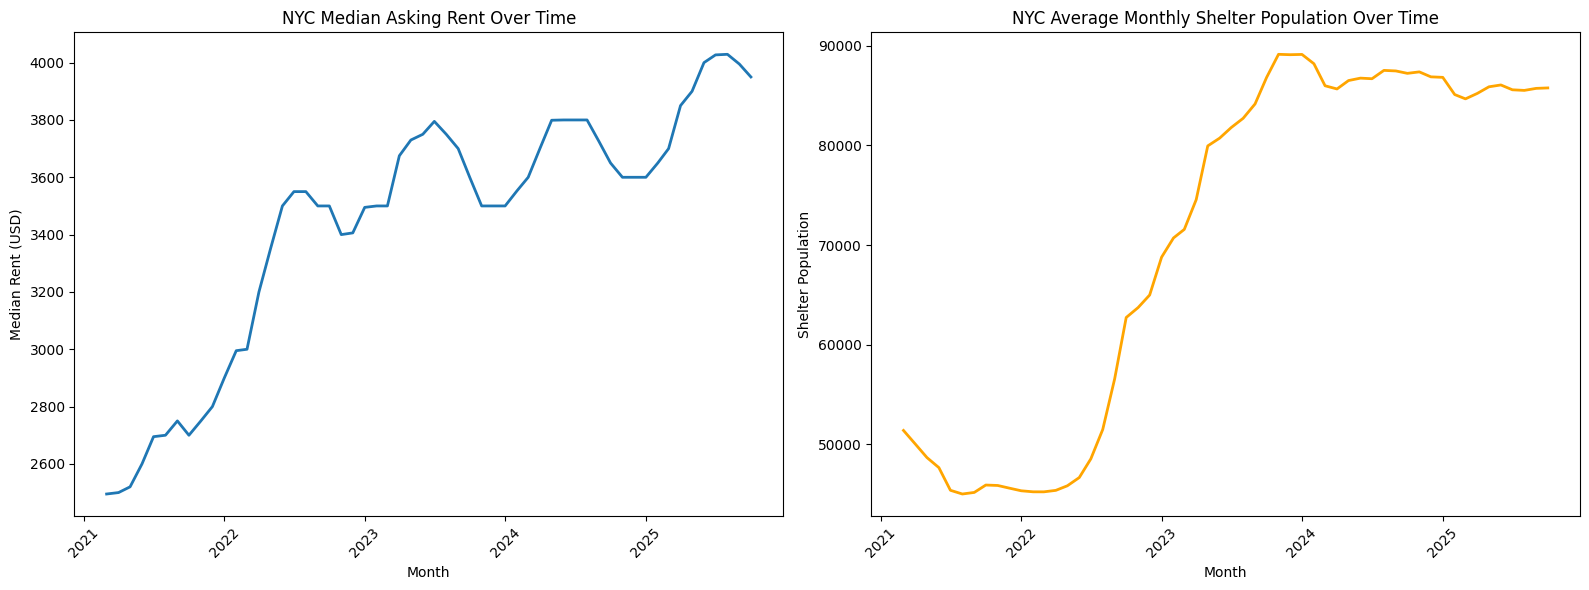

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#Median Rent Over Time
axes[0].plot(df_joined["month"], df_joined["median_rent"], linewidth=2)
axes[0].set_title("NYC Median Asking Rent Over Time")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Median Rent (USD)")
axes[0].tick_params(axis="x", rotation=45)

#Average Shelter Population Over Time
axes[1].plot(df_joined["month"], df_joined["total_shelter_avg"], linewidth=2, color="orange")
axes[1].set_title("NYC Average Monthly Shelter Population Over Time")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Shelter Population")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

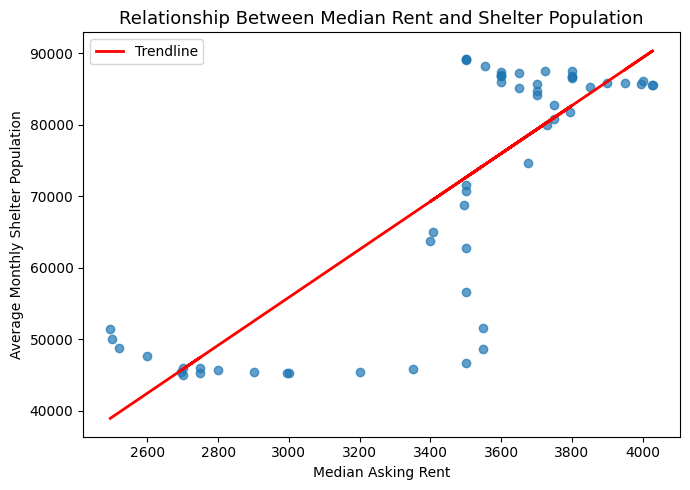

In [13]:
plt.figure(figsize=(7, 5))

# Scatter points
plt.scatter(df_joined["median_rent"], df_joined["total_shelter_avg"], alpha=0.7)

# Add Trendline
x = df_joined["median_rent"]
y = df_joined["total_shelter_avg"]

# Fit a linear regression
m, b = np.polyfit(x, y, 1)

# Plot the line
plt.plot(x, m*x + b, color="red", linewidth=2, label="Trendline")

plt.title("Relationship Between Median Rent and Shelter Population", fontsize=13)
plt.xlabel("Median Asking Rent")
plt.ylabel("Average Monthly Shelter Population")
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
# Define X and y
X = df_joined["median_rent"]
y = df_joined["total_shelter_avg"]

# Add constant for intercept
X = sm.add_constant(X)

# Fit linear regression
model = sm.OLS(y, X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total_shelter_avg   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     111.4
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           9.82e-15
Time:                        23:31:39   Log-Likelihood:                -596.07
No. Observations:                  56   AIC:                             1196.
Df Residuals:                      54   BIC:                             1200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.472e+04    1.1e+04     -4.060      0.000   -6.68e+04   -2.26e+04
median_rent    33.5165      3.176     10.553      0.000      27.149      39.884
==============================================================================
Omnibus:                        5.572   Durbin-Watson:                   0.087
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                4.759
Skew:                          -0.697   Prob(JB):                       0.0926
Kurtosis:                       3.309   Cond. No.                     2.77e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Interpretation of Results

The two time-series plots show how median asking rent and the average monthly shelter population have evolved over time in New York City. Median rent displays a generally upward trend, reflecting the city’s increasing housing costs. The shelter population also shows variation over time, with periods where the number of individuals in shelter rises alongside increases in rent.

The scatterplot provides a direct view of the association between the two variables. The points suggest a positive relationship: higher median rent values tend to coincide with higher shelter populations. While this does not imply causation, it is consistent with the idea that rising housing costs may contribute to greater housing instability and increased reliance on the shelter system.

Overall, the visual patterns indicate that changes in housing affordability and homelessness may be connected. Further analysis would be needed to establish a causal link, but these results provide initial descriptive evidence of a relationship between rent levels and shelter population in New York City.


## Regression Model interpretation

The regression model shows a strong and statistically significant relationship between median asking rent and the size of the homeless shelter population in New York City. The coefficient indicates that each $1 increase in median rent is associated with an increase of approximately 33 individuals in shelter, on average. This coefficient however, is not reliable as the model doesn't account for omitted variables.  The model explains about 67% of the variation in shelter population, suggesting that housing costs are closely tied to homelessness trends in the city.

However, the very sharp growth in shelter population after 2022 is likely influenced by additional factors not captured in this simple model, such as migration flows, economic conditions, and policy changes. Therefore, while rent levels appear to be an important predictor, they do not fully explain the rise in homelessness.


## Limitations of the Model

This regression is a simple, descriptive model and should be interpreted with caution. While it shows a strong association between median rent and shelter population, several important limitations remain:

1. **Omitted Variables and Confounders**
   Because important factors that influence homelessness are omitted from the model, the estimated effect of median rent is likely biased and should not be interpreted as a precise causal relationship.

2. **Time-Series Autocorrelation**
    The Durbin–Watson statistic indicates serial correlation, which violates the assumptions of ordinary least squares. This means the regression’s standard errors and significance levels may not be fully reliable.

3. **Causality Cannot Be Inferred**
   This analysis is correlational. Although higher rents and higher homelessness levels move together, the model cannot determine whether increases in rent cause increases in homelessness. More rigorous causal methods or additional control variables would be required.


Overall, the regression provides useful descriptive insight but should not be interpreted as a causal estimate. A more sophisticated model with additional variables would be needed to better understand the drivers of homelessness.


## Conclusion

This analysis examined the relationship between median asking rent and the size of the homeless shelter population in New York City using monthly data. Both the visualizations and the regression results indicate a positive association. Periods of higher rent levels tend to coincide with higher shelter populations. While this relationship does not establish causality, the findings suggest that housing costs are closely aligned with homelessness trends in the city. Additional variables and more advanced modeling would be needed to better understand the underlying mechanisms, but these results provide initial evidence that affordability pressures may contribute to increased reliance on the shelter system.
